# Modelado de Tópicos en las reseñas de Amazon

Support material:
[Basic tasks with spacy](https://necronet.github.io/Spacy-getting-started-in-spanish/)

A more advanced article: [Topic Modeling on Spanish Texts](https://medium.com/@armandj.olivares/topic-modeling-on-spanish-text-f7a5e998fb90) 

In [38]:
import pandas as pd
import numpy as np
import gensim
import re
from gensim.corpora import Dictionary
import nltk
import spacy

In [39]:
train_data = pd.read_json('../data/dataset_es_train.json', lines=True)
test_data = pd.read_json('../data/dataset_es_test.json', lines=True)

In [40]:
all_data = pd.concat([train_data, test_data])

In [23]:
all_data.sample(10)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes
5,es_0779978,product_es_0103315,reviewer_es_0304973,1,Jamás me llegó y el vendedor nunca contacto co...,Jamás me llegó,es,home
6,es_0591840,product_es_0880915,reviewer_es_0642702,1,"El paraguas es de muy mala calidad,da la sensa...",Horroroso!!!,es,luggage
7,es_0173297,product_es_0814677,reviewer_es_0895784,1,Tuve que devolverla porque al ser triangular n...,Poco funcional,es,office_product
8,es_0101300,product_es_0654228,reviewer_es_0789283,1,Estoy esperando despues de protestar varias ve...,No me llego,es,electronics
9,es_0487007,product_es_0877793,reviewer_es_0986278,1,"Defectuoso. En apariencia muy bien producto, p...","Mala calidad, defectuoso",es,kitchen


In [44]:
all_data["review"] = all_data["review_title"] + all_data["review_body"]

### Cleaning the raw text and obtaining a corpus
For Topic Clustering we must do some preprocessing to the text before we can feed it to an LDA model.
A common approach is to use only the nouns, dismissing the verbs, adjectives and adverbs.
Sometimes bigrams are used (e.g. 'No aprendemos', 'en línea', 'bien planeado'), but since we are only using nouns we might want to explore keywords first.

1. Lemmatize the words
2. Use bigrams **
3. Using POS tagging to subselect only nouns
4. Clean the remaining text from punctuation, etc.

In [45]:
# remove stopwords from every review
stopwords = set(nltk.corpus.stopwords.words("spanish"))

In [46]:
# For tokenization, tagging, lemmatization, stemming and NER
nlp = spacy.load("es_core_news_md")

In [47]:
def normalize_tokenize_lemmatize(text):
    doc = nlp(text)
    VALID_POS = {'PROPN', 'NOUN'}
    # Avoid empty word in beggining with doc[1:]
    return [word.lemma_ for word in doc if word.lemma_ not in stopwords 
                                            and word.pos_ in VALID_POS]

In [48]:
# Takes a few minutes
all_data['text'] = all_data['review'].apply(normalize_tokenize_lemmatize)

In [49]:
all_data['text']

0       [television, NevirNada, bueno, ka, pantalla, m...
1       [Dinero, basura, comprahorrible, inglés, infor...
2                  [unidad, doste, unidad, forma, estafa]
3       [PRODUCTO, vendedor, mes, espera, producto, Am...
4                              [DevueltoLlega, co, talla]
                              ...                        
4995    [función, sobra, color, envío, plazo, incidencia]
4996                    [vendedor, material, descripción]
4997                         [medalla, bonito, grabadose]
4998              [bici, xiaomi, modelo, timbre, manilla]
4999    [auricular, cable, verdadPues, tipo, casco, in...
Name: text, Length: 205000, dtype: object

#### Transform the text into a bag of words corpus for the model

In [50]:
dictionary = Dictionary(all_data['text'].to_list())

In [51]:
# Assign ids to every word without gaps
dictionary.compactify()

# Filter out words that appear in less than 2 documents, thos appearing in more than 97% of corpus, and keep all other words
dictionary.filter_extremes(no_below=2, no_above=0.97, keep_n=None)

# Reassign ids to every word without gaps after filtering
dictionary.compactify()   

In [52]:
corpus = [dictionary.doc2bow(text) for text in all_data['text']]

### Feeding the corpus to the LDA Model


- We try a number of topics from 1 to 20 and looks for the best coherence measurement

In [53]:
texts = all_data['text'].to_list()

In [54]:
# Find the optimal number of topics based on coherence
from gensim.models import LdaModel
from gensim.models import CoherenceModel

MAX_TOPICS = 20
coherence_vals = []
lm_list = []

for n_topics in range(1, MAX_TOPICS+1):
    lm = LdaModel(corpus=corpus, num_topics = n_topics, id2word=dictionary)

    lm_list.append(lm)
    
    cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_vals.append(cm.get_coherence())

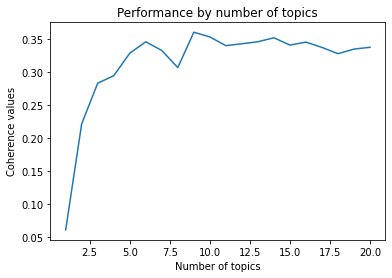

In [56]:
import matplotlib.pyplot as plt

plt.plot(range(1, MAX_TOPICS+1), coherence_vals)
plt.title('Performance by number of topics')
plt.xlabel('Number of topics')
plt.ylabel('Coherence values')
plt.show()

From the results we can see that **6** topics is probably the best model (coherence value `0.35522555294632824`)

In [57]:
model_8topics = lm_list[7]
model_8topics.print_topics()

[(0,
  '0.031*"relación" + 0.026*"luz" + 0.025*"año" + 0.020*"libro" + 0.018*"batería" + 0.018*"cable" + 0.016*"sonido" + 0.015*"hora" + 0.013*"uso" + 0.011*"carga"'),
 (1,
  '0.147*"producto" + 0.026*"vendedor" + 0.024*"descripción" + 0.024*"problema" + 0.020*"expectativa" + 0.015*"tiempo" + 0.014*"Perfecto" + 0.014*"servicio" + 0.012*"dinero" + 0.011*"sabor"'),
 (2,
  '0.050*"casa" + 0.023*"paquete" + 0.023*"trabajo" + 0.017*"mochila" + 0.016*"gusto" + 0.014*"día" + 0.014*"rapidez" + 0.014*"ordenador" + 0.013*"tarjeta" + 0.012*"envio"'),
 (3,
  '0.046*"regalo" + 0.040*"día" + 0.034*"compra" + 0.026*"entrega" + 0.025*"momento" + 0.023*"hija" + 0.021*"hijo" + 0.018*"fecha" + 0.015*"gracia" + 0.015*"gracias"'),
 (4,
  '0.049*"funda" + 0.044*"pantalla" + 0.041*"móvil" + 0.023*"teléfono" + 0.020*"protector" + 0.020*"cristal" + 0.020*"medida" + 0.019*"perfección" + 0.016*"parte" + 0.015*"tacto"'),
 (5,
  '0.039*"foto" + 0.035*"tal" + 0.029*"caja" + 0.018*"función" + 0.018*"niño" + 0.018*"p

## Note
December 2021 update: analysis was made with the `md` model (8 topics) instead of the previous `sm` model (6 topics), so results may be different. 